In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import pandas as pd
import sympy as sym
import warnings
import pickle as plk
from IPython.display import display, Math
from numpy.lib.scimath import sqrt as csqrt
from scipy.signal import find_peaks

import os
import imp
import sys
import importlib.util

###############################################################
# LINUX PATH

sys.path.append("/opt/lumerical/v221/api/python") #Default linux lumapi path
import lumapi
sys.path.append(os.path.dirname('/home/trainner/Documentos/Caio/GitReps/Photonics-training/Projects/Optical_Hybrid/SimulationFiles')) #Current directory

###############################################################
# WINDOWS PATH

# spec_win = importlib.util.spec_from_file_location('lumapi', 'C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py')
# lumapi = importlib.util.module_from_spec(spec_win)
# os.add_dll_directory("C:/Program Files/Lumerical/v202/api/python")
# sys.path.append(os.path.dirname('C:/Users/Caio/Documents/GitHub/Photonics-training/Projects/Optical_Hybrid/SimulationFiles/'))
# spec_win.loader.exec_module(lumapi)

###############################################################
# TERMINAL FILE PATH
# /opt/lumerical/v221/bin/fdtd-engine-mpich2nem /home/trainner/Documentos/Caio/GitReps/Photonics-training/Projects/Optical_Hybrid/SimulationFiles/MMIHybrid.fsp -t 8
# /opt/lumerical/v221/bin/fdtd-engine-mpich2nem /home/trainner/Documentos/Caio/GitReps/Photonics-training/Projects/Optical_Hybrid/SimulationFiles/MMIHybrid_s-parametersweep/s-parametersweep_1.fsp -t 8



/tmp/ipykernel_73627/1930891817.py:13: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [2]:
hyb = lumapi.FDTD(filename='MMIHybrid.fsp',hide=False) 

## Functions

In [6]:
# Search for function's intersections on signal levels
def signalLv(yarray,level,type):
    peak, pd = find_peaks(yarray)
    maxpeak = yarray[peak[np.argmax(yarray[peak])]]
    minpeak = yarray[np.argmin(yarray)]
    index = []

    if(type == 'linear'):
        lvpeak = (maxpeak - minpeak)*level + minpeak
        for i in range(0,np.size(yarray)-1):
            if(((maxpeak-yarray[i]) - (maxpeak-lvpeak)) * ((maxpeak-yarray[i+1]) - (maxpeak-lvpeak)) <= 0):
                index.append(i)
        yMed = (yarray[index[0]] + yarray[index[-1]])/2

    if(type == 'log10'):
        lvpeak = maxpeak + 10*np.log10(level)
        for i in range(0,np.size(yarray)-1):
            if(((maxpeak-yarray[i]) - (maxpeak-lvpeak)) * ((maxpeak-yarray[i+1]) - (maxpeak-lvpeak)) <= 0):
                index.append(i)
        yMed = 10*np.log10((10**(yarray[index[0]]/2) + 10**(yarray[index[1]]/2))/2)

    return {'index':index,'yMed':yMed}


# Creates a box
def RectInsert(X,XSPAN,Y,YSPAN,Z,ZSPAN,MATERIAL,lumerical):
    
    lumerical.switchtolayout()
    lumerical.addrect()
    lumerical.set({"x":X,"y":Y,"z":Z,
         "x span":XSPAN, "y span":YSPAN, "z span":ZSPAN,
         "material":MATERIAL
        })


# Format a function/dataset as a polygon
def PolyForm(x,y,ybase):
    y2 = y + ybase
    A = np.zeros((2,len(x)+2))
    
    A[0][1:len(x)+1] = x
    A[1][1:len(x)+1] = y2
    A[0][0] = x[0]
    A[0][len(x)+1] = x[-1]
    A[1][0] = ybase
    A[1][len(x)+1] = ybase
    
    return A

## Assembly Parameters

In [4]:
# Topology ------------------------------------
InnerBd = 2* 1.6e-6  # Inner body X span (Sum of both parts)
OuterBd = 2* 2.4e-6  # Outer body X span (Sum of both parts)

CentWid = 1.48e-6  # Central Width
InnerWid = 1.48e-6  # Inner Width
OuterWid = 1.6e-6  # Outer Width

TLen = 1e-6  # Tapper length

Buried = 1  # Activate buried topology

Material = "Si (Silicon) - Palik"

BendS = 0  # Without bends (0) , Insert S-bend on ports (1) , Insert 90-bend on ports (2)


# Simulation ----------------------------------
FDTDAccuracy = 5  # FDTD mesh accuracy

simTime = 3000e-15  # Simulation time

MeshEnable = 0  # Enable/Disable mesh
MSBd = {"dx":10e-9, "dy":4e-9, "dz":50e-9}  # Mesh maximum steps Body
MSPt = {"dx":10e-9, "dy":7e-9, "dz":50e-9}  # Mesh maximum steps Ports

## Assembly

In [10]:
hyb.switchtolayout()
hyb.deleteall()

# Creating the Full Body
Verts = np.array([[0,CentWid/2], [InnerBd/2,InnerWid/2], [(InnerBd+OuterBd)/2,OuterWid/2],
         [(InnerBd+OuterBd)/2,-OuterWid/2], [InnerBd/2,-InnerWid/2], [0,-CentWid/2],
         [-InnerBd/2,-InnerWid/2], [-(InnerBd+OuterBd)/2,-OuterWid/2],
         [-(InnerBd+OuterBd)/2,OuterWid/2], [-InnerBd/2,InnerWid/2]])   # Vertices

hyb.addpoly()
hyb.set("name", "FullBody")
hyb.set("vertices",Verts)
hyb.set({"x":0, "y":0, "z":0, "z span":220e-9,
        "material":Material})


# Creating the substract
if(Buried==0):
        RectInsert(0, OuterBd+InnerBd+2*TLen+4e-6, 0, OuterWid*2, -1e-6-110e-9, 2e-6, "SiO2 (Glass) - Palik", hyb)
        hyb.set("name","Substract")


# Creating the Tappers
GenPar = {"first axis":"z", "z":0,
         "len":TLen, "thickness":0.22e-6,
         "width_r":0.7e-6, "width_l":0.5e-6, 
         "angle_side":90}    # General parameter sets

hyb.addobject("linear_taper")
hyb.set(GenPar)
hyb.set({"rotation 1":0, "name":"Input Taper 1",
         "x":-TLen/2-(InnerBd+OuterBd)/2, "y":OuterWid/2 - 0.35e-6})

hyb.addobject("linear_taper")
hyb.set(GenPar)
hyb.set({"rotation 1":0, "name":"Input Taper 2",
         "x":-TLen/2-(InnerBd+OuterBd)/2, "y":-OuterWid/2 + 0.35e-6})

hyb.addobject("linear_taper")
hyb.set(GenPar)
hyb.set({"rotation 1":180, "name":"Output Taper 1",
         "x":TLen/2+(InnerBd+OuterBd)/2, "y":OuterWid/2 - 0.35e-6})

hyb.addobject("linear_taper")
hyb.set(GenPar)
hyb.set({"rotation 1":180, "name":"Output Taper 2",
         "x":TLen/2+(InnerBd+OuterBd)/2, "y":-OuterWid/2 + 0.35e-6})


# Creating the post-tapper waveguides
RectInsert(-6e-6, 2e-6, 0.45e-6, 0.5e-6, 0, 220e-9, Material,hyb)
hyb.set("name", "Input waveguide 1")
RectInsert(-6e-6, 2e-6, -0.45e-6, 0.5e-6, 0, 220e-9, Material,hyb)
hyb.set("name", "Input waveguide 2")
RectInsert(6e-6, 2e-6, 0.45e-6, 0.5e-6, 0, 220e-9, Material,hyb)
hyb.set("name", "Output waveguide 1")
RectInsert(6e-6, 2e-6, -0.45e-6, 0.5e-6, 0, 220e-9, Material,hyb)
hyb.set("name", "Output waveguide 2")

# Creating the post-tapper bends



# Creating FDTD region
hyb.addfdtd()
hyb.set({"x":0, "y":0, "z":0,
         "x span":OuterBd+InnerBd+2*TLen+1e-6, "y span": OuterWid*1.65, "z span":3e-6,
         "simulation time":simTime, "mesh accuracy":FDTDAccuracy})
if(Buried==1):
        hyb.set("background material","SiO2 (Glass) - Palik")


# Creating monitor region
hyb.addpower()  # Planar monitor
hyb.set({"x":0, "x span":OuterBd+InnerBd+2*TLen, "y":0, "y span":OuterWid*1.65})
hyb.setglobalmonitor("use source limits",0)
hyb.setglobalmonitor("minimum wavelength",1500e-9)
hyb.setglobalmonitor("maximum wavelength",1600e-9)
hyb.setglobalmonitor("frequency points",20)


# Creating mesh region
if(MeshEnable == 1):
        hyb.addmesh()
        hyb.set({"x":0, "y":0, "z":0,
                "x span":OuterBd+InnerBd, "y span":OuterWid, "z span":220e-9,
                "name":"BodyMesh"})
        hyb.set("set maximum mesh step",1)
        hyb.set({"dx":MSBd["dx"],"dy":MSBd["dy"],"dz":MSBd["dz"]})

        hyb.addmesh()
        hyb.set({"x":-TLen/2-(InnerBd+OuterBd)/2, "y":0.45e-6, "z":0,
                "x span":TLen, "y span":0.7e-6, "z span":220e-9,
                "name":"Port1 Mesh"})
        hyb.set("set maximum mesh step",1)
        hyb.set({"dx":MSPt["dx"],"dy":MSPt["dy"],"dz":MSPt["dz"]})

        hyb.addmesh()
        hyb.set({"x":TLen/2+(InnerBd+OuterBd)/2, "y":0.45e-6, "z":0,
                "x span":TLen, "y span":0.7e-6, "z span":220e-9,
                "name":"Port3 Mesh"})
        hyb.set("set maximum mesh step",1)
        hyb.set({"dx":MSPt["dx"],"dy":MSPt["dy"],"dz":MSPt["dz"]})

        hyb.addmesh()
        hyb.set({"x":TLen/2 +(InnerBd+OuterBd)/2, "y":-0.45e-6, "z":0,
                "x span":TLen, "y span":0.7e-6, "z span":220e-9,
                "name":"Port4 Mesh"})
        hyb.set("set maximum mesh step",1)
        hyb.set({"dx":MSPt["dx"],"dy":MSPt["dy"],"dz":MSPt["dz"]})


# Creating Ports
hyb.addport()
hyb.set({"x":-5e-6, "y":0.45e-6, "z":0,
         "y span":0.75e-6, "z span":3e-6,
         "direction":"Forward"})

hyb.addport()
hyb.set({"x":-5e-6, "y":-0.45e-6, "z":0,
         "y span":0.75e-6, "z span":3e-6,
         "direction":"Forward"})

hyb.addport()
hyb.set({"x":5e-6, "y":0.45e-6, "z":0,
         "y span":0.55e-6, "z span":3,
         "direction":"Backward"})

hyb.addport()
hyb.set({"x":5e-6, "y":-0.45e-6, "z":0,
         "y span":0.55e-6, "z span":3e-6,
         "direction":"Backward"})


# Editing source settings
hyb.select('FDTD::ports')
hyb.set('monitor frequency points',1500)
hyb.setglobalsource("wavelength start", 1500e-9)
hyb.setglobalsource("wavelength stop", 1600e-9)

1.0

## Mesh convergence sweep

In [12]:
# Sweep configs
SPoints = 6      # Sweep points
SRange = [2,7]  # Sweep range
Name = "Mesh_sweep"

# Sweep creation
hyb.deletesweep(Name)
hyb.addsweep(0)
hyb.setsweep("sweep","name",Name)
hyb.setsweep(Name,"type","Ranges")
hyb.setsweep(Name,"number of points",SPoints)

MeshParameter = {"Name":"Mesh accuracy", "Type":"Number",
               "Parameter":"::model::FDTD::mesh accuracy",
               "Start":SRange[0], "Stop":SRange[1]}

Transmission_In = {"Name":"Transmission In",
                   "Result":"::model::FDTD::ports::port 1::T"}
Transmission_Through = {"Name":"Transmission Through",
                     "Result":"::model::FDTD::ports::port 3::T"}
Transmission_Cross = {"Name":"Transmission Cross",
                     "Result":"::model::FDTD::ports::port 4::T"}

hyb.addsweepparameter(Name,MeshParameter)
hyb.addsweepresult(Name,Transmission_In)
hyb.addsweepresult(Name,Transmission_Through)
hyb.addsweepresult(Name,Transmission_Cross)

'Transmission Cross'

dict_keys(['lambda', 'f', 'Mesh accuracy', 'T', 'Lumerical_dataset'])
(1500, 6)
dict_keys(['lambda', 'f', 'Mesh accuracy', 'T', 'Lumerical_dataset'])
(1500, 6)
dict_keys(['lambda', 'f', 'Mesh accuracy', 'T', 'Lumerical_dataset'])
(1500, 6)


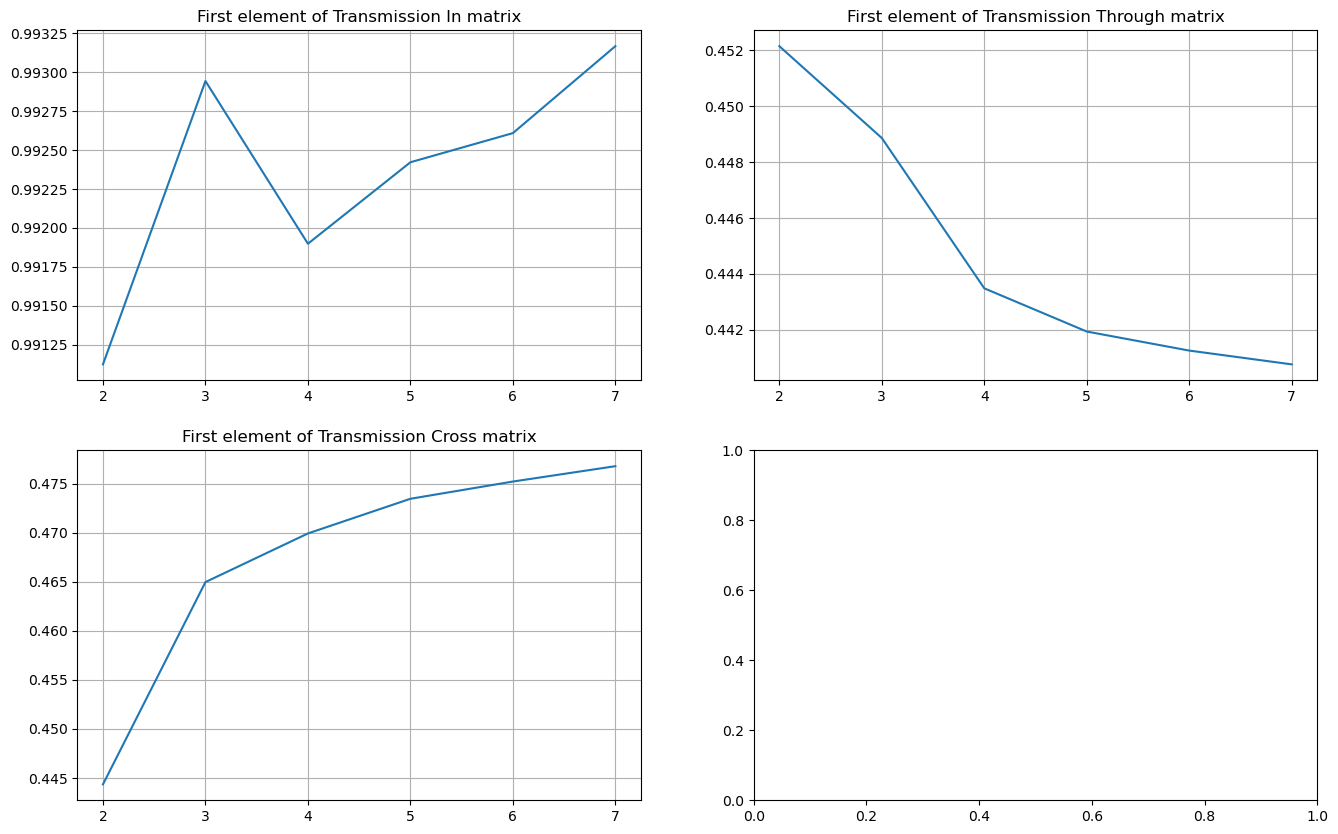

In [13]:
fig, ax = plt.subplots(2,2,figsize=(16,10))
sweepMatrix = ["Transmission In","Transmission Through","Transmission Cross"]
for j in range(3):    
    dataSet = hyb.getsweepresult("Mesh_sweep",sweepMatrix[j])
    subSet = dataSet['T']
    xSet = dataSet['Mesh accuracy']

    print(dataSet.keys())
    print(np.shape(subSet))

    TSet = []
    for i in range(len(subSet[0,:])):
        TSet.append(subSet[0,i])

    win = [int( j/2 ) , int( j%2 )] # Window plot indexes
    ax[win[0]][win[1]].plot(xSet[0,:],TSet)
    ax[win[0]][win[1]].grid(True)
    ax[win[0]][win[1]].set_title("First element of {} matrix".format(sweepMatrix[j]))

## Load Power field

dict_keys(['lambda', 'f', 'x', 'y', 'z', 'P', 'Lumerical_dataset'])
(419, 86, 1, 20, 3)


Text(0.5, 1.0, 'Power distribution 1551.02nm')

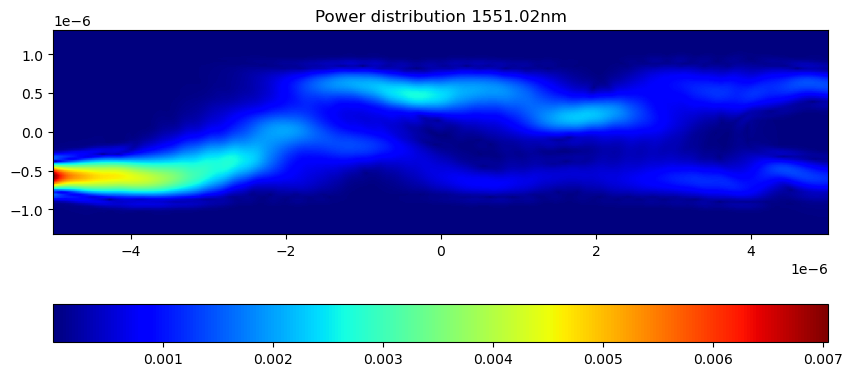

In [18]:
fIndex = 9  # Frequency index

P = hyb.getresult("monitor","P")
PwrArray = np.array(P['P'])
print(P.keys())
print(np.shape(PwrArray))

Px = PwrArray[:,:,0,fIndex,0]
Py = PwrArray[:,:,0,fIndex,1]
Pz = PwrArray[:,:,0,fIndex,2]

PAbs = np.sqrt(np.multiply(Px,Px) + np.multiply(Py,Py) + np.multiply(Py,Py))
Ax = ([ float(P['x'][0]) , float(P['x'][-1]) ])
Ay = ([ float(P['y'][0]) , float(P['y'][-1]) ])

# Plotting the color graph
plt.figure(figsize=(10,6))
ax = plt.imshow(np.abs(np.transpose(PAbs)),cmap ='jet', extent=[Ax[0],Ax[1],Ay[0],Ay[1]])
plt.colorbar(orientation='horizontal')
plt.title('Power distribution {:.2f}nm'.format(1e9*float(P['lambda'][fIndex])))

## Load Transmission

dict_keys(['lambda', 'f', 'T', 'Lumerical_dataset'])


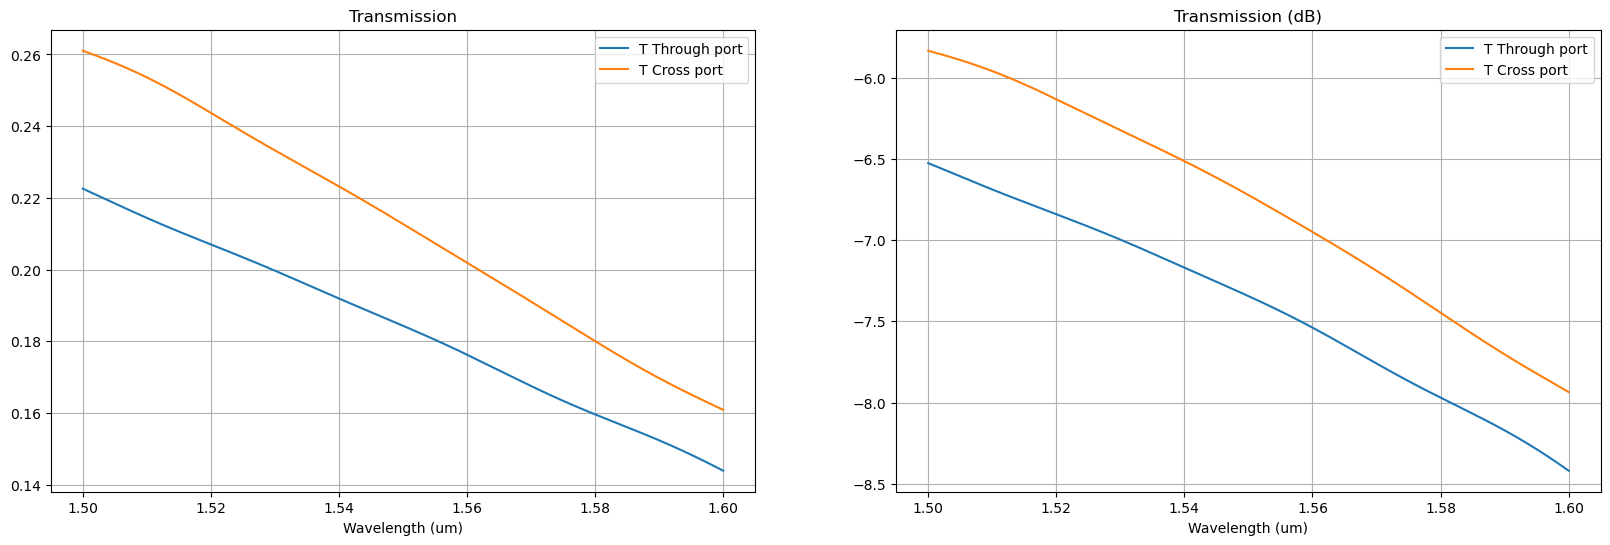

In [17]:
T3 = hyb.getresult("FDTD::ports::port 3","T")
T4 = hyb.getresult("FDTD::ports::port 4","T")

print(T3.keys())
fig, ax = plt.subplots(1,2,figsize=(20,6))
ax[0].plot(T3['lambda']*1e6, T3['T'], label='T Through port')
ax[0].plot(T4['lambda']*1e6, T4['T'], label='T Cross port')
ax[0].set_title('Transmission')
ax[0].set_xlabel('Wavelength (um)')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(T3['lambda']*1e6, 10*np.log10(T3['T']), label='T Through port')
ax[1].plot(T4['lambda']*1e6, 10*np.log10(T4['T']), label='T Cross port')
ax[1].set_title('Transmission (dB)')
ax[1].set_xlabel('Wavelength (um)')
ax[1].grid(True)
ax[1].legend()

## Load S-parameters

dict_keys(['lambda', 'f', 'S11', 'S21', 'S31', 'Lumerical_dataset'])


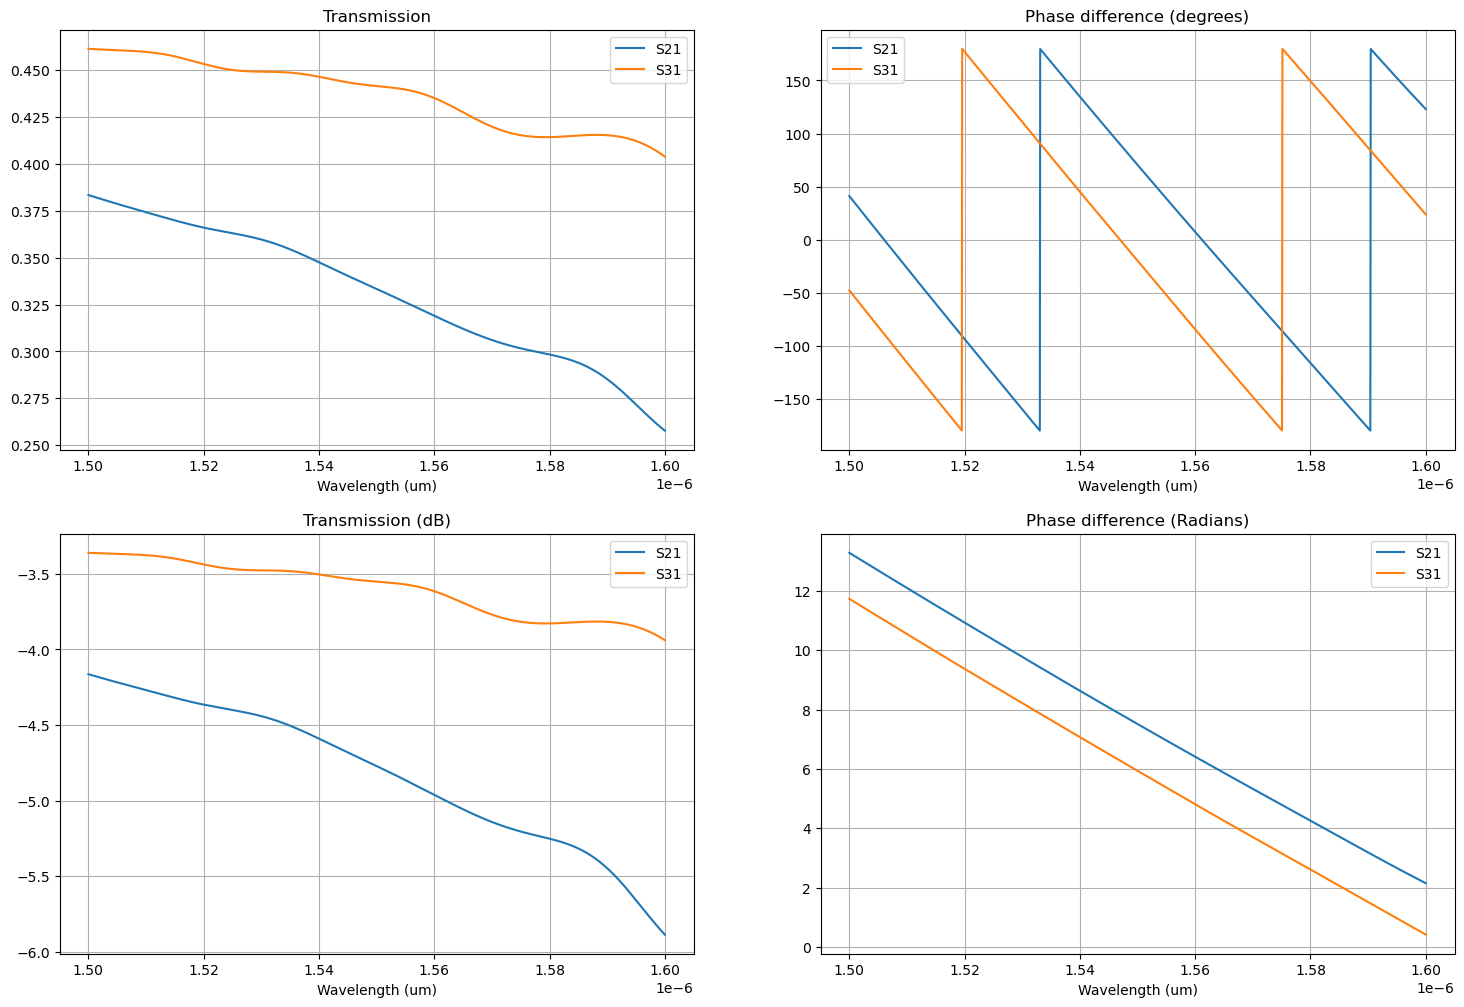

In [26]:
S = hyb.getsweepresult("s-parameter sweep", "S parameters")
print(S.keys())

SPort2 = S['S21']
SPort3 = S['S31']
fig, ax= plt.subplots(2,2,figsize=(18,12))
ax[0][0].plot(S['lambda'],np.abs(SPort2)**2, label='S21')
ax[0][0].plot(S['lambda'],np.abs(SPort3)**2, label='S31')
ax[0][0].set_title('Transmission')
ax[0][0].set_xlabel('Wavelength (um)')
ax[0][0].grid(True)
ax[0][0].legend() 

ax[0][1].plot(S['lambda'],hyb.unwrap(np.angle(SPort2)), label='S21')
ax[0][1].plot(S['lambda'],hyb.unwrap(np.angle(SPort3)), label='S31')
ax[0][1].set_title('Phase (radians)')
ax[0][1].set_xlabel('Wavelength (um)')
ax[0][1].grid(True)
ax[0][1].legend()

ax[1][0].plot(S['lambda'],10*np.log10(np.abs(SPort2)**2), label='S21')
ax[1][0].plot(S['lambda'],10*np.log10(np.abs(SPort3)**2), label='S31')
ax[1][0].set_title('Transmission (dB)')
ax[1][0].set_xlabel('Wavelength (um)')
ax[1][0].grid(True)
ax[1][0].legend()

ax[1][1].plot(S['lambda'],hyb.unwrap(np.angle(SPort2), degree=True) - hyb.unwrap(np.angle(SPort3), degree=True), label='Phase Difference', color='g')
ax[1][1].set_title('Phase difference (Degrees)')
ax[1][1].set_xlabel('Wavelength (um)')
ax[1][1].grid(True)
ax[1][1].legend()